In [1]:
! pip install nltk
! pip install nlp
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.9
    Uninstalling dill-0.3.9:
      Successfully uninstalled dill-0.3.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the 

In [2]:
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Embedding, Activation, Dropout
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import nlp
import nltk
from datasets import load_dataset
import random
from sklearn.preprocessing import label_binarize, LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


In [3]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.17.1


In [4]:
dataset = load_dataset('emotion')
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

https://huggingface.co/datasets/dair-ai/emotion

classes: 0-sadness, 1-joy, 2-love, 3-anger, 4-fear, 5-surpise

In [5]:
train_ds = dataset['train']
val_ds = dataset['validation']
test_ds = dataset['test']

In [6]:
def get_data(df):
  tweets = [tweet for tweet in df['text']]
  labels = [label for label in df['label']]
  return tweets, labels

In [7]:
train_tweets, train_labels = get_data(train_ds)
val_tweets, val_labels = get_data(val_ds)
test_tweets, test_labels = get_data(test_ds)

In [8]:
print(train_tweets[0:5])
print(test_labels[0:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']
[0, 0, 0, 1, 0]


In [9]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")  # OOV token for out-of-vocabulary words
tokenizer.fit_on_texts(train_tweets)

In [10]:
lengths = [len(tweet.split()) for tweet in train_tweets]
max_len = max(lengths)

In [11]:
max_len

66

In [12]:
train_seq = tokenizer.texts_to_sequences(train_tweets)
train_padded = pad_sequences(train_seq, maxlen=max_len, padding='post', truncating='post')

val_seq = tokenizer.texts_to_sequences(val_tweets)
val_padded = pad_sequences(val_seq, maxlen=max_len, padding='post', truncating='post')

test_seq = tokenizer.texts_to_sequences(test_tweets)
test_padded = pad_sequences(test_seq, maxlen=max_len, padding='post', truncating='post')

In [13]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

# One-hot encode labels
train_labels = to_categorical(train_labels, num_classes=6)
val_labels = to_categorical(val_labels, num_classes=6)
test_labels = to_categorical(test_labels, num_classes=6)

In [14]:
from tensorflow.keras.layers import GRU

model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=66),
    GRU(256, return_sequences=True),
    GRU(128, return_sequences=False),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(6, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0015),
              loss='categorical_crossentropy',  # Use 'categorical_crossentropy' for multi-class
              metrics=['accuracy'])

model.build(input_shape=(None, 66))  # Batch size is None, sequence length is 66
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 66, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 66, 256)             │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 128)                 │         148,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,741,958 (6.65 MB)

 Trainable params: 1,741,958 (6.65 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
h = model.fit(train_padded, train_labels, epochs=20, validation_data=(val_padded, val_labels), batch_size=64)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.3169 - loss: 1.6102 - val_accuracy: 0.3520 - val_loss: 1.5855
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3246 - loss: 1.5871 - val_accuracy: 0.3520 - val_loss: 1.5833
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3327 - loss: 1.5839 - val_accuracy: 0.3520 - val_loss: 1.5832
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3347 - loss: 1.5783 - val_accuracy: 0.3520 - val_loss: 1.5813
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3288 - loss: 1.5787 - val_accuracy: 0.3520 - val_loss: 1.5823
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3298 - loss: 1.5825 - val_accuracy: 0.3520 - val_loss: 1.5801
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3521 - loss: 1.5202 - val_accuracy: 0.7365 - val_loss: 0.7051
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7860 - loss: 0.5824 - val_acc

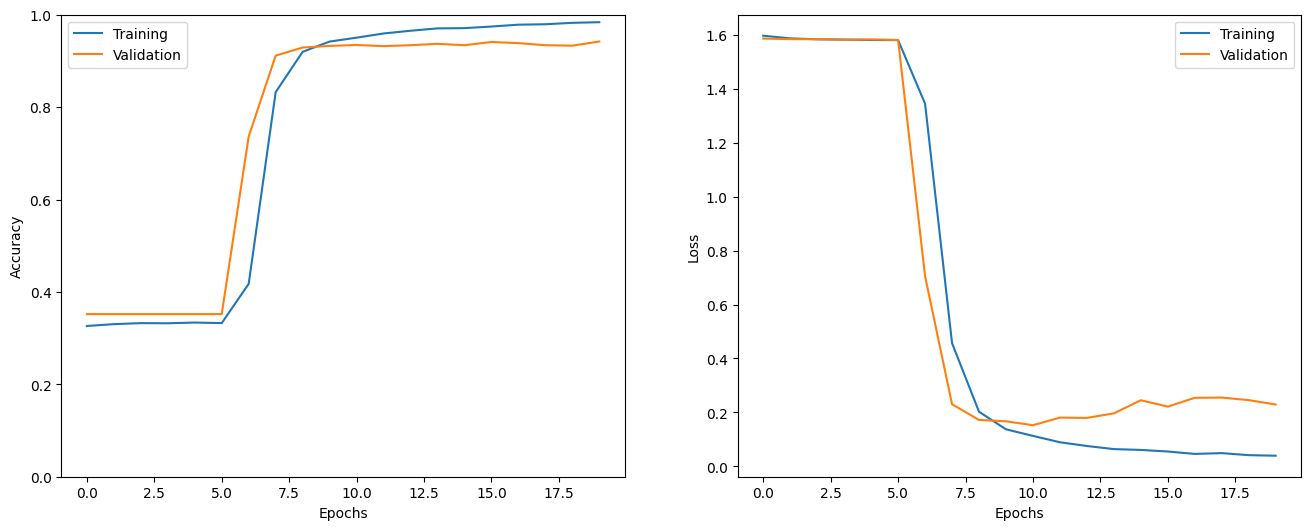

In [16]:
show_history(h)

In [17]:
model.evaluate(test_padded, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9233 - loss: 0.2689


[0.2583075761795044, 0.9294999837875366]

In [28]:
# Expand dimensions to match the expected input shape
sample_input = tf.expand_dims(test_padded[0], axis=0)  # Shape: (1, 66)

# Get predictions
predictions = model.predict(sample_input)
predicted_class = np.argmax(predictions, axis=-1)
print(predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
[0]


In [18]:
model.save('emotion_model.h5')

In [51]:
def test_tweet(tweet):
    tokenized_tweet = tokenizer.texts_to_sequences([tweet])
    padded_tweet = pad_sequences(tokenized_tweet, maxlen=max_len, padding='post', truncating='post')
    prediction = model.predict(padded_tweet)
    predicted_class = np.argmax(prediction, axis=-1)
    # classes: 0-sadness, 1-joy, 2-love, 3-anger, 4-fear, 5-surpise
    if predicted_class[0]==0:
      emotion = "sadness"
    elif predicted_class[0]==1:
      emotion = "joy"
    elif predicted_class[0]==2:
      emotion = "love"
    elif predicted_class[0]==3:
      emotion = "anger"
    elif predicted_class[0]==4:
      emotion = "fear"
    elif predicted_class[0]==5:
      emotion = "surprise"
    return f'Overal emotional category of the given text is: {emotion}'

In [60]:
tweet = "the wedding is in morning"
test_tweet(tweet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


'Overal emotional category of the given text is: anger'